# DO Amaïlys
# SOLAR Alexis
# M2A

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

In [1]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [2]:
import torch
import torch.nn as nn

from tqdm import tqdm

In [3]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

matplotlib.use("TkAgg")

Matplotlib backend: module://matplotlib_inline.backend_inline


# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [4]:
def actor_critic(
    mdp: MazeMDPEnv,
    alpha_critic: float = 0.5,
    alpha_actor: float = 0.5,
    nb_episodes: int = 20,
    timeout: int = 50,
    render: bool = False,
    uniform: bool = True,
):
    
    # initialisation
    v = np.zeros(mdp.unwrapped.nb_states)
    v_min = np.zeros(mdp.unwrapped.nb_states)
    policy = np.array([[1/mdp.action_space.n for _ in range(mdp.action_space.n)] for _ in range(mdp.unwrapped.nb_states)]) # uniform initialisation of the policy
    time_list = []
    v_list = []
    
    mdp.timeout = timeout  # episode length
    
    if render:
        mdp.unwrapped.init_draw("actor_critic")
        
    for _ in range(nb_episodes):
        
        # first episode
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0
        
        
        terminated = False
        truncated = False
        while not (terminated or truncated):
            if render:
                mdp.unwrapped.draw_v_pi(v, policy)
            
            a = np.random.choice([action for action in range(mdp.action_space.n)], p=policy[x]) # action choice according to the policy
            y, r, terminated, truncated, _ = mdp.step(a)
            delta = r + mdp.unwrapped.gamma * (1-terminated) * v[y] - v[x]
            
            # critic update
            v[x] += alpha_critic * delta
            
            # policy_temp update
            policy_temp = np.zeros(mdp.action_space.n)
                
            for action in range(mdp.action_space.n):
                if action != a:
                    policy_temp[action] = policy[x,action]
                else:
                    policy_temp[action] = max(policy[x,a] + alpha_actor * delta, 1e-8)
            
            # policy update
            policy[x] = policy_temp / np.sum(policy_temp)
            
            x = y
            cpt += 1
        
        v_list.append(np.linalg.norm(np.maximum(v, v_min)))
        time_list.append(cpt)
                
    if render:
        mdp.current_state = 0
        mdp.unwrapped.draw_v_pi(v, policy)
    
    return v, v_list, time_list, policy

### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [5]:
def sampling(env, nb_episodes=100, timeout=50, nb_sample=50, alpha_critic = 0.5, alpha_actor = 0.5):
    
    v_sample, v_list_sample, time_list_sample, policy_sample = [], [], [], []
    
    for _ in range(nb_sample):
        
        v, v_list, time_list, policy = actor_critic(
        env, nb_episodes=nb_episodes, timeout=timeout, render=False, alpha_critic = alpha_critic, alpha_actor=alpha_actor
        )
        v_sample.append(v)
        v_list_sample.append(v_list)
        time_list_sample.append(time_list)
        policy_sample.append(policy)
        
        
    return v_sample, v_list_sample, time_list_sample, policy_sample


def plot_nb_steps(time_list_sample, save_curves=False):
    plt.clf()
    
    # Convertir en numpy array pour faciliter les calculs
    time_list_sample = np.array(time_list_sample)
    
    # Calcul de la moyenne et de l'écart-type
    mean_steps = np.mean(time_list_sample, axis=0)
    std_steps = np.std(time_list_sample, axis=0)
    
    # Tracer la moyenne et l'écart-type
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(mean_steps)), mean_steps, label="Mean", color='blue')
    plt.fill_between(range(len(mean_steps)), mean_steps - std_steps, mean_steps + std_steps, color='blue', alpha=0.2, label="standard deviation")

    # Tracer quelques courbes individuelles avec transparence
    num_samples_to_plot = min(5, len(time_list_sample))  # Limiter à 5 courbes maximum
    for i in range(num_samples_to_plot):
        plt.plot(range(len(time_list_sample[i])), time_list_sample[i], label=f"Run {i+1}", alpha=0.4)

    plt.xlabel("Number of episodes")
    plt.ylabel("Number of step to reach the reward")
    plt.title(f"Number of step to reach the reward over episodes (Sample size: {len(time_list_sample)})")
    plt.legend(loc="upper right")
    
    if save_curves:
        plt.savefig('nb_steps2.png', dpi=300)
    
    plt.show()
    
    
def plot_convergence(v_list_sample, save_curves=False):
    plt.clf()
    
    # Convertir en numpy array pour faciliter les calculs
    v_list_sample = np.array(v_list_sample)
    
    # Calcul de la moyenne et de l'écart-type
    mean_steps = np.mean(v_list_sample, axis=0)
    std_steps = np.std(v_list_sample, axis=0)
    
    # Tracer la moyenne et l'écart-type
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(mean_steps)), mean_steps, label="Mean", color='blue')
    plt.fill_between(range(len(mean_steps)), mean_steps - std_steps, mean_steps + std_steps, color='blue', alpha=0.2, label="standard deviation")

    # Tracer quelques courbes individuelles avec transparence
    num_samples_to_plot = min(5, len(v_list_sample))  # Limiter à 5 courbes maximum
    for i in range(num_samples_to_plot):
        plt.plot(range(len(v_list_sample[i])), v_list_sample[i], label=f"Run {i+1}", alpha=0.4)

    plt.xlabel("Number of episodes")
    plt.ylabel("Norm of V functions")
    plt.title(f"convergence rate (Sample size: {len(v_list_sample)})")
    plt.legend(loc='center right')
    
    if save_curves:
        plt.savefig('convergence_rate2.png', dpi=300)
    
    plt.show()
    
def plot_distrib_policy(policy_sample, policy, save_curves=False):
    plt.clf()
    
    nombre_states_optimal = np.sum(np.argmax(policy_sample, axis=2) == policy, axis=1)
    
    pourcentage_states_optimal = (nombre_states_optimal / 20) * 100

    # Création d'un histogramme avec Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Tracer l'histogramme avec des pourcentages
    sns.histplot(pourcentage_states_optimal, kde=True, color='blue', bins=9)

    # Personnalisation du graphique
    plt.title(f"Distribution du pourcentage de states suivant la politique optimale ({len(policy_sample)} samples)", fontsize=16)
    plt.xlabel("Pourcentage de states suivant la politique optimale (%)", fontsize=14)
    plt.ylabel("Fréquence", fontsize=14)
    
    if save_curves:
        plt.savefig('optimal_policy_distribution.png', dpi=300)
    
    plt.show()

In [6]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    """Outputs a policy given the state values"""

    # Sets initial state values are set to 0
    policy = np.zeros(mdp.nb_states)  

    # Loop over MDP states
    for x in range(mdp.nb_states):
        if x in mdp.terminal_states:
            # Takes the reward associated with the terminal state
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            # Compute the value V(x) for state x
            v_temp = []
            
            # Loop over actions
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

def value_iteration_v(
    mdp: MazeMDPEnv, render: bool = True
):
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    mdp.init_draw("Value iteration V")

    mdp.draw_v(v)

    while not stop:
        v_old = v.copy()
        mdp.draw_v(v)

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x in mdp.terminal_states:
                v[x] = np.max(mdp.r[x, :])
            else:
                v_temp = []
                for u in range(mdp.action_space.n):
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    policy = get_policy_from_v(mdp, v)
    mdp.draw_v_pi(v, policy)
    return v, v_list

## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [9]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array",
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": False, # True, # 
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

conf = OmegaConf.create(ac_params)

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

<Figure size 640x480 with 0 Axes>

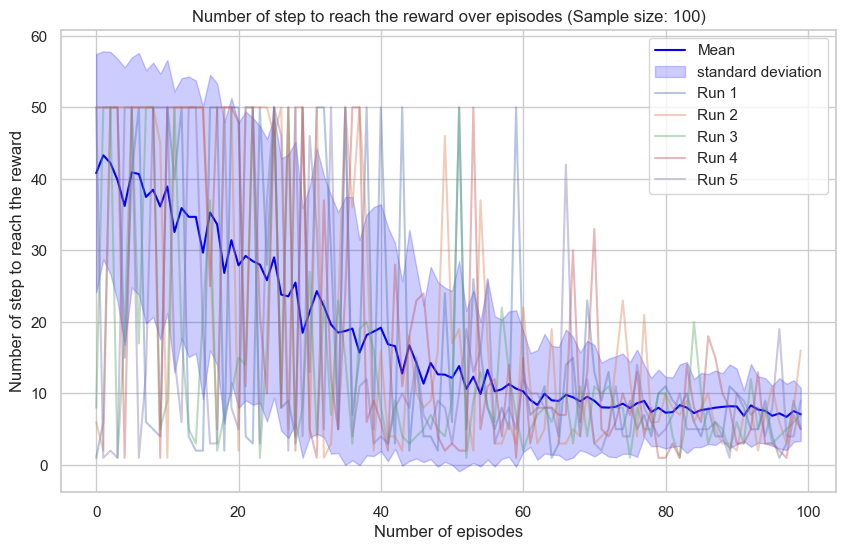

<Figure size 640x480 with 0 Axes>

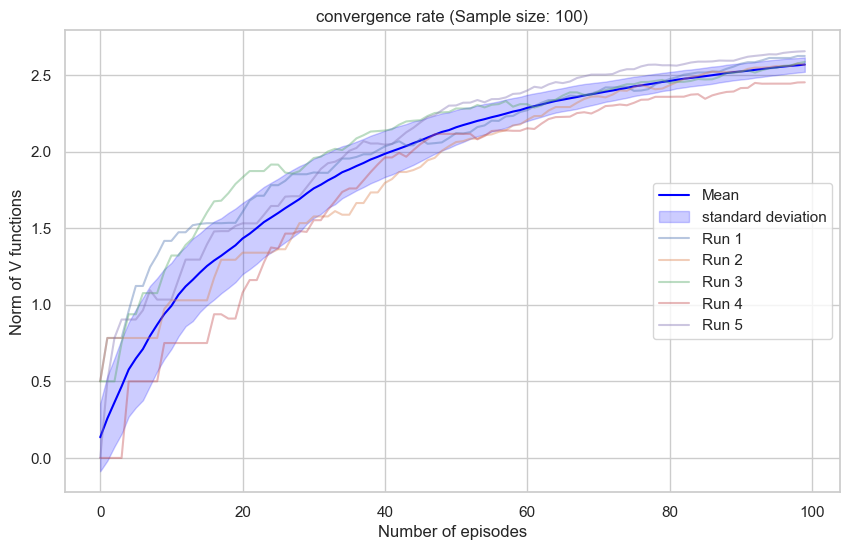

<Figure size 640x480 with 0 Axes>

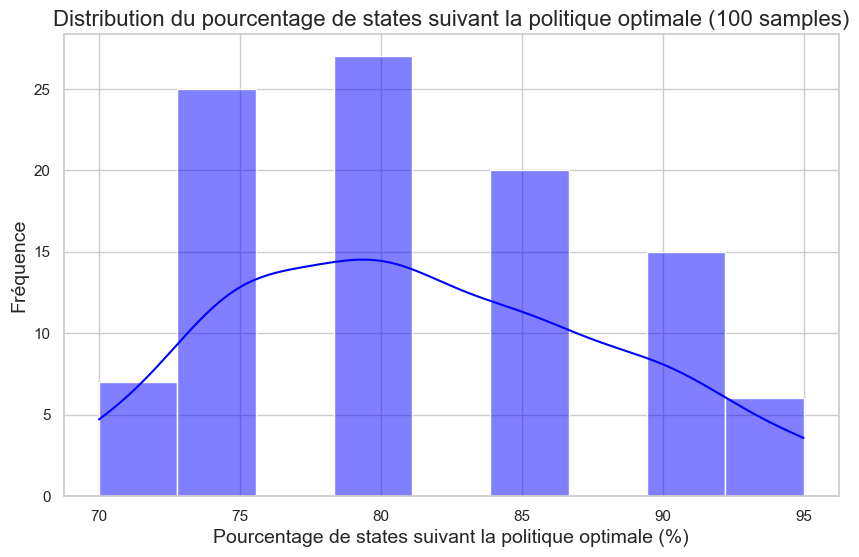

In [10]:
torch.manual_seed(0)

env = gym.make(
    conf.mdp.name,
    kwargs={"width": conf.mdp.width, "height": conf.mdp.width, "ratio": conf.mdp.ratio, "hit": 0.0},
    render_mode=conf.mdp.render_mode,
)

%matplotlib inline

v_sample, v_list_sample, time_list_sample, policy_sample = sampling(env, nb_episodes=conf.nb_episodes,  nb_sample=100)
plot_nb_steps(time_list_sample, conf.save_curves)
plot_convergence(v_list_sample, conf.save_curves)

v, v_list = value_iteration_v(env.unwrapped, render=False)
pi = get_policy_from_v(env.unwrapped, v)
plot_distrib_policy(policy_sample, pi, False)

<Figure size 640x480 with 0 Axes>

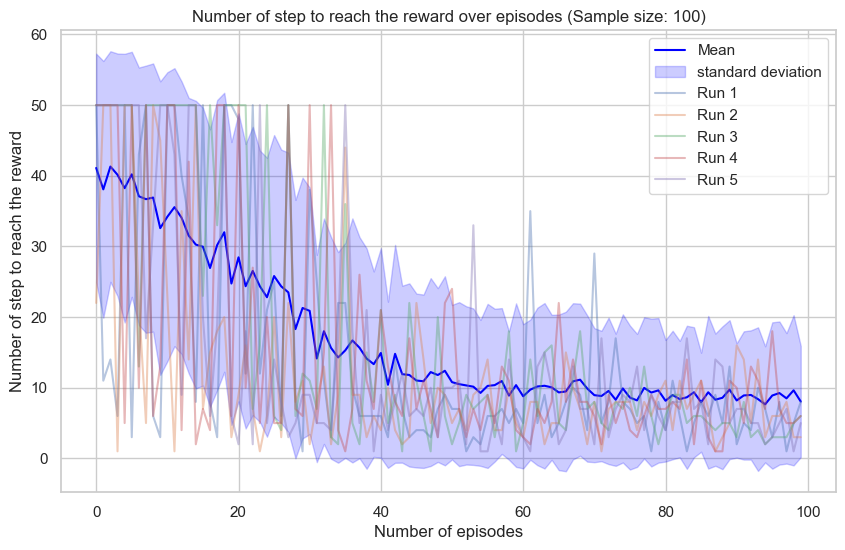

<Figure size 640x480 with 0 Axes>

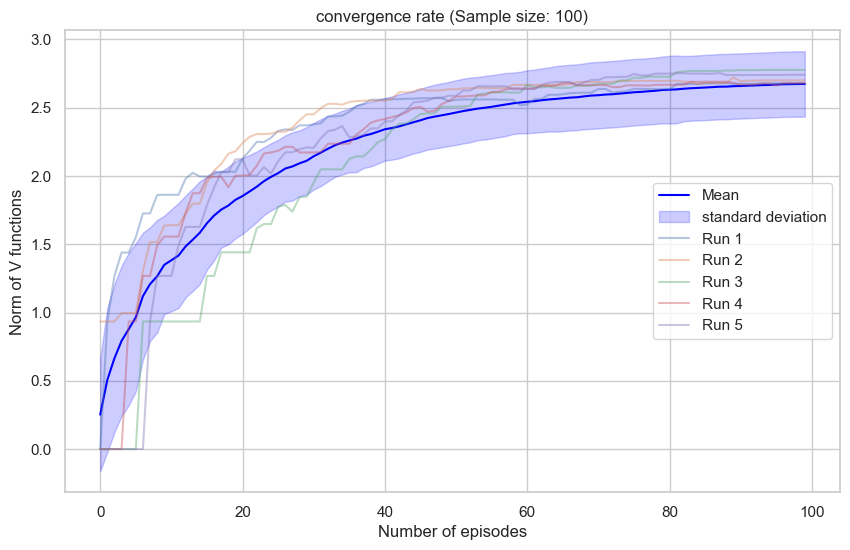

<Figure size 640x480 with 0 Axes>

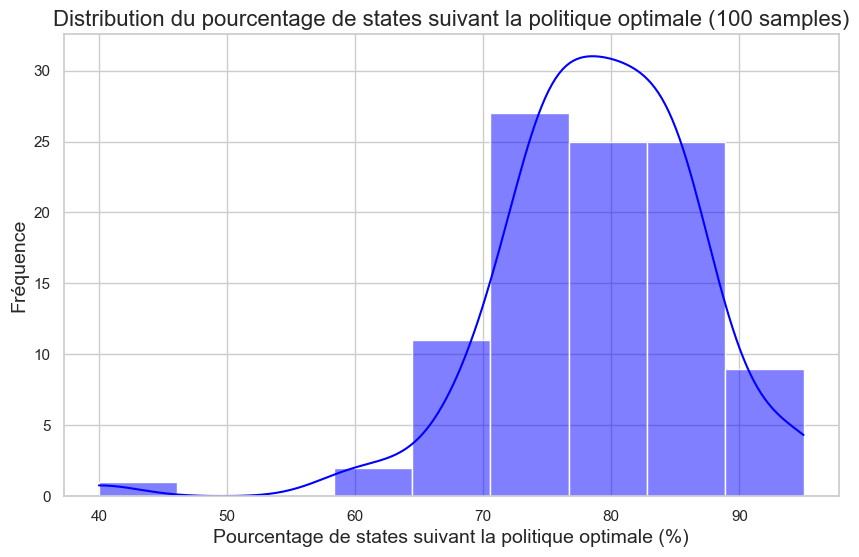

In [11]:
v_sample2, v_list_sample2, time_list_sample2, policy_sample2 = sampling(env, nb_episodes=conf.nb_episodes,  nb_sample=100, alpha_actor=0.996948471965022, alpha_critic=0.9342176253498784)
plot_nb_steps(time_list_sample2, conf.save_curves)
plot_convergence(v_list_sample2, conf.save_curves)

plot_distrib_policy(policy_sample2, pi, False)

# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

In [9]:
def train_actor_critic(actor_lr, critic_lr, env, nb_episodes=100):
    
    _, v_list_sample, _, _ = sampling(env, nb_sample=nb_episodes, nb_episodes=nb_episodes, alpha_critic = critic_lr, alpha_actor = actor_lr)
    
    avg_norm_V_function = np.mean(v_list_sample, axis=0)
    
    return avg_norm_V_function[-1]


def grid_search(env, actor_lr_list, critic_lr_list, nb_episodes=100):
    results = {}
    
    for actor_lr in tqdm(actor_lr_list):
        for critic_lr in tqdm(critic_lr_list, leave=False):
            # print(f"Training with actor_lr={actor_lr}, critic_lr={critic_lr}")
            avg_norm_V_function = train_actor_critic(actor_lr, critic_lr, env, nb_episodes)
            results[(actor_lr, critic_lr)] = avg_norm_V_function
            
    return results

def objective(trial):
    actor_lr = trial.suggest_float('actor_lr', 0, 1) 
    critic_lr = trial.suggest_float('critic_lr', 0, 1)

    # Train the actor-critic algorithm and get the performance metric
    avg_norm_V_function = train_actor_critic(actor_lr, critic_lr, env, nb_episodes=100)
    
    return avg_norm_V_function  # maximize this metric 

def optimize_hyperparameters(env, n_trials=100):
    study = optuna.create_study(direction='maximize')  # Change to 'maximize' if needed
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params, study.best_value, study

# Gridsearch

In [20]:
critic_lr_list = np.linspace(1e-4, 1-1e-4, 20)
actor_lr_list = np.linspace(1e-4, 1-1e-4, 20)

results = grid_search(actor_lr_list=actor_lr_list, critic_lr_list=critic_lr_list, env=env, nb_episodes=100)

100%|██████████| 20/20 [46:42<00:00, 140.11s/it]


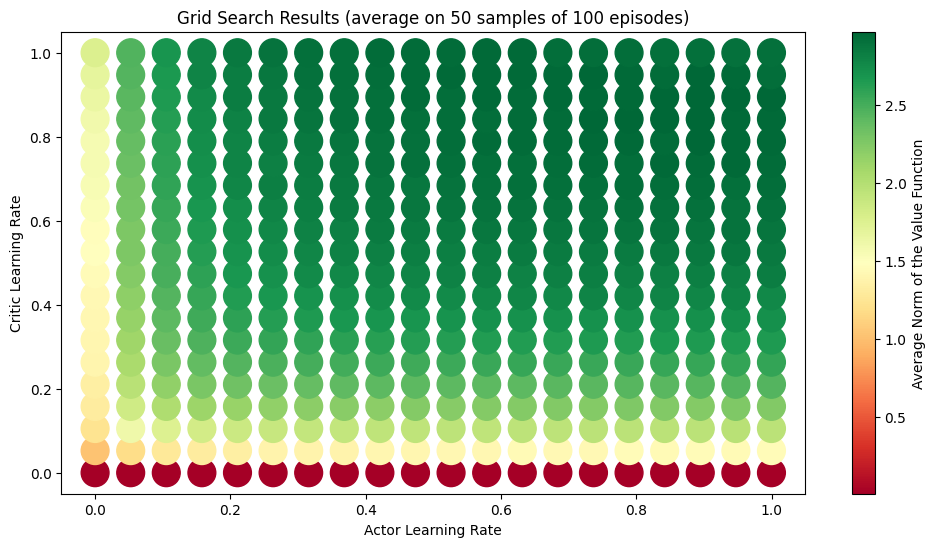

In [21]:
# Plot grid search results
actor_lrs = [lr[0] for lr in results.keys()]
critic_lrs = [lr[1] for lr in results.keys()]
avg_norm_V_function = [results[lr] for lr in results.keys()]

plt.figure(figsize=(12, 6))
plt.scatter(actor_lrs, critic_lrs, c=avg_norm_V_function, cmap='RdYlGn', s=400)
plt.colorbar(label='Average Norm of the Value Function')
plt.xlabel('Actor Learning Rate')
plt.ylabel('Critic Learning Rate')
plt.title('Grid Search Results (average on 50 samples of 100 episodes)')
plt.savefig('grid_search_heatmap.png', dpi=300)
plt.show()

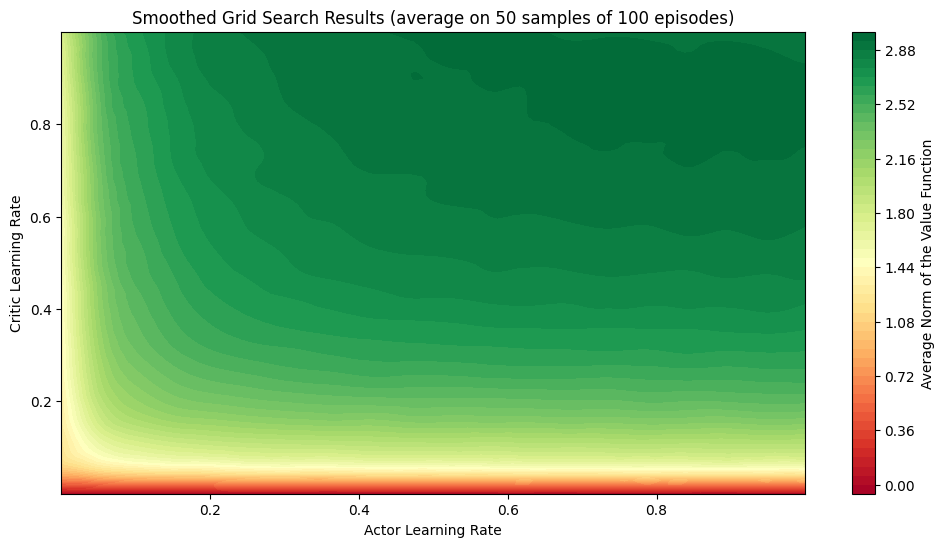

In [22]:


# Convertir les listes d'apprentissage des acteurs et des critiques en arrays
actor_lrs = np.array(actor_lrs)
critic_lrs = np.array(critic_lrs)
avg_norm_V_function = np.array(avg_norm_V_function)

# Créer un meshgrid des valeurs d'actor_lr et critic_lr
grid_x, grid_y = np.mgrid[
    min(actor_lrs):max(actor_lrs):100j, 
    min(critic_lrs):max(critic_lrs):100j
]

# Interpoler les valeurs des résultats pour lisser la heatmap
grid_z = griddata((actor_lrs, critic_lrs), avg_norm_V_function, (grid_x, grid_y), method='cubic')

# Créer la figure
plt.figure(figsize=(12, 6))

# Afficher la heatmap avec l'interpolation
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='RdYlGn')

# Ajouter une barre de couleur
plt.colorbar(contour, label='Average Norm of the Value Function')

# Ajouter des étiquettes et un titre
plt.xlabel('Actor Learning Rate')
plt.ylabel('Critic Learning Rate')
plt.title('Smoothed Grid Search Results (average on 50 samples of 100 episodes)')
plt.savefig('smoothed_grid_search_heatmap.png', dpi=300)
# Afficher la heatmap
plt.show()

In [24]:
# Trier les résultats par valeur de manière décroissante
top_10 = sorted(results.items(), key=lambda x: x[1], reverse=True)[:10]

# Afficher les 10 clés et leurs valeurs associées
for i, (cle, valeur) in enumerate(top_10, 1):
    print(f"{i}. Clé : {cle}, Valeur : {valeur}")

1. Clé : (0.8420368421052632, 0.8946578947368421), Valeur : 2.969385669299649
2. Clé : (0.9999, 0.8946578947368421), Valeur : 2.9684769749668396
3. Clé : (0.9472789473684211, 0.8946578947368421), Valeur : 2.963957417822477
4. Clé : (0.8946578947368421, 0.8420368421052632), Valeur : 2.963694973919191
5. Clé : (0.8946578947368421, 0.9472789473684211), Valeur : 2.961511233664666
6. Clé : (0.7894157894736843, 0.8420368421052632), Valeur : 2.9610226709085445
7. Clé : (0.7367947368421053, 0.8420368421052632), Valeur : 2.960835501703088
8. Clé : (0.8946578947368421, 0.8946578947368421), Valeur : 2.960276065816338
9. Clé : (0.7367947368421053, 0.9472789473684211), Valeur : 2.9593568204638148
10. Clé : (0.8946578947368421, 0.7894157894736843), Valeur : 2.9581658855803856


1. Clé : (0.8420368421052632, 0.8946578947368421), Valeur : 2.969385669299649
2. Clé : (0.9999, 0.8946578947368421), Valeur : 2.9684769749668396
3. Clé : (0.9472789473684211, 0.8946578947368421), Valeur : 2.963957417822477
4. Clé : (0.8946578947368421, 0.8420368421052632), Valeur : 2.963694973919191
5. Clé : (0.8946578947368421, 0.9472789473684211), Valeur : 2.961511233664666
6. Clé : (0.7894157894736843, 0.8420368421052632), Valeur : 2.9610226709085445
7. Clé : (0.7367947368421053, 0.8420368421052632), Valeur : 2.960835501703088
8. Clé : (0.8946578947368421, 0.8946578947368421), Valeur : 2.960276065816338
9. Clé : (0.7367947368421053, 0.9472789473684211), Valeur : 2.9593568204638148
10. Clé : (0.8946578947368421, 0.7894157894736843), Valeur : 2.9581658855803856

# Bayesian Optimisation

In [48]:
best_params, best_value, study = optimize_hyperparameters(env, n_trials=400)

[I 2024-09-29 15:33:27,232] A new study created in memory with name: no-name-4785f17d-65a2-46b2-ac01-f90230035142
[I 2024-09-29 15:33:31,297] Trial 0 finished with value: 2.8932565924903315 and parameters: {'actor_lr': 0.8855273129311245, 'critic_lr': 0.3910434175650177}. Best is trial 0 with value: 2.8932565924903315.
[I 2024-09-29 15:33:36,399] Trial 1 finished with value: 2.898112931733672 and parameters: {'actor_lr': 0.22858082372484992, 'critic_lr': 0.6258218606638509}. Best is trial 1 with value: 2.898112931733672.
[I 2024-09-29 15:33:41,550] Trial 2 finished with value: 2.8243417569914224 and parameters: {'actor_lr': 0.4106327325686963, 'critic_lr': 0.37045873349781105}. Best is trial 1 with value: 2.898112931733672.
[I 2024-09-29 15:33:47,501] Trial 3 finished with value: 2.810861960312165 and parameters: {'actor_lr': 0.15287156315574, 'critic_lr': 0.6131031639602804}. Best is trial 1 with value: 2.898112931733672.
[I 2024-09-29 15:33:51,612] Trial 4 finished with value: 2.9950

In [61]:
# Print best parameters from Bayesian optimization
print(f"Best parameters: {best_params}")
print(f"Best value (average steps): {best_value}")

# Visualiser l'historique de l'optimisation
optuna.visualization.plot_optimization_history(study)

Best parameters: {'actor_lr': 0.996948471965022, 'critic_lr': 0.9342176253498784}
Best value (average steps): 3.110415645751039


In [50]:
optuna.visualization.plot_contour(study)

In [51]:
optuna.visualization.plot_param_importances(study)

In [53]:
optuna.visualization.plot_slice(study)

In [54]:
optuna.visualization.plot_rank(study)

In [63]:
# Extraire les essais et les valeurs
trials = study.trials

# Trier les essais par valeur décroissante
sorted_trials = sorted(trials, key=lambda trial: trial.value, reverse=True)

# Récupérer les 10 meilleurs essais
top_n = 10
best_trials = sorted_trials[:top_n]

# Afficher les meilleurs paramètres et leurs valeurs
for i, trial in enumerate(best_trials):
    print(f"Rank {i + 1}: Params: {trial.params}, Value: {trial.value}")

Rank 1: Params: {'actor_lr': 0.996948471965022, 'critic_lr': 0.9342176253498784}, Value: 3.110415645751039
Rank 2: Params: {'actor_lr': 0.981351728949575, 'critic_lr': 0.9200957825365517}, Value: 3.1089075516431346
Rank 3: Params: {'actor_lr': 0.9207206993904186, 'critic_lr': 0.9589960404238561}, Value: 3.108798792732378
Rank 4: Params: {'actor_lr': 0.979326057728725, 'critic_lr': 0.9320202823345884}, Value: 3.10700540835612
Rank 5: Params: {'actor_lr': 0.9570505842132517, 'critic_lr': 0.9085550841195588}, Value: 3.1053912443235645
Rank 6: Params: {'actor_lr': 0.9957200917177622, 'critic_lr': 0.9106186979131438}, Value: 3.104562816321182
Rank 7: Params: {'actor_lr': 0.9494000238304273, 'critic_lr': 0.9383007518647924}, Value: 3.1031512959662093
Rank 8: Params: {'actor_lr': 0.979956655845999, 'critic_lr': 0.8889732969748271}, Value: 3.102077719389123
Rank 9: Params: {'actor_lr': 0.9820140418647909, 'critic_lr': 0.877171862829679}, Value: 3.101550413990734
Rank 10: Params: {'actor_lr': 0

1. Rank 1: Params: {'actor_lr': 0.996948471965022, 'critic_lr': 0.9342176253498784}, Value: 3.110415645751039
2. Rank 2: Params: {'actor_lr': 0.981351728949575, 'critic_lr': 0.9200957825365517}, Value: 3.1089075516431346
3. Rank 3: Params: {'actor_lr': 0.9207206993904186, 'critic_lr': 0.9589960404238561}, Value: 3.108798792732378
4. Rank 4: Params: {'actor_lr': 0.979326057728725, 'critic_lr': 0.9320202823345884}, Value: 3.10700540835612
5. Rank 5: Params: {'actor_lr': 0.9570505842132517, 'critic_lr': 0.9085550841195588}, Value: 3.1053912443235645
6. Rank 6: Params: {'actor_lr': 0.9957200917177622, 'critic_lr': 0.9106186979131438}, Value: 3.104562816321182
7. Rank 7: Params: {'actor_lr': 0.9494000238304273, 'critic_lr': 0.9383007518647924}, Value: 3.1031512959662093
8. Rank 8: Params: {'actor_lr': 0.979956655845999, 'critic_lr': 0.8889732969748271}, Value: 3.102077719389123
9. Rank 9: Params: {'actor_lr': 0.9820140418647909, 'critic_lr': 0.877171862829679}, Value: 3.101550413990734
10. Rank 10: Params: {'actor_lr': 0.9773736198936945, 'critic_lr': 0.8867012602880606}, Value: 3.1006873075221284

# randomsearch

In [10]:
sampler = optuna.samplers.RandomSampler()

study3 = optuna.create_study(sampler=sampler, direction="maximize")
study3.optimize(objective, n_trials=400)

[I 2024-10-04 10:53:42,437] A new study created in memory with name: no-name-7322d8fb-b39c-4a96-8c5c-634c86145fc5
[I 2024-10-04 10:53:56,208] Trial 0 finished with value: 1.1543041566848224 and parameters: {'actor_lr': 0.17320010175054912, 'critic_lr': 0.058360760802049105}. Best is trial 0 with value: 1.1543041566848224.
[I 2024-10-04 10:54:03,460] Trial 1 finished with value: 2.7010215791557233 and parameters: {'actor_lr': 0.5168110974898183, 'critic_lr': 0.6069054958027602}. Best is trial 1 with value: 2.7010215791557233.
[I 2024-10-04 10:54:13,631] Trial 2 finished with value: 2.10957078191372 and parameters: {'actor_lr': 0.48153023983532195, 'critic_lr': 0.18551107887741558}. Best is trial 1 with value: 2.7010215791557233.
[I 2024-10-04 10:54:23,347] Trial 3 finished with value: 2.1658100685234243 and parameters: {'actor_lr': 0.39086449565310066, 'critic_lr': 0.2078789623474685}. Best is trial 1 with value: 2.7010215791557233.
[I 2024-10-04 10:54:33,245] Trial 4 finished with valu

In [12]:
optuna.visualization.plot_optimization_history(study3)

In [13]:
optuna.visualization.plot_rank(study3)

In [14]:
# Extraire les essais et les valeurs
trials3 = study3.trials

# Trier les essais par valeur décroissante
sorted_trials3 = sorted(trials3, key=lambda trial: trial.value, reverse=True)

# Récupérer les 10 meilleurs essais
top_n = 10
best_trials3 = sorted_trials3[:top_n]

# Afficher les meilleurs paramètres et leurs valeurs
for i, trial in enumerate(best_trials3):
    print(f"Rank {i + 1}: Params: {trial.params}, Value: {trial.value}")

Rank 1: Params: {'actor_lr': 0.9996250766782451, 'critic_lr': 0.8527263525050737}, Value: 2.808797076352405
Rank 2: Params: {'actor_lr': 0.8814579413400233, 'critic_lr': 0.8340700149656324}, Value: 2.806159203725435
Rank 3: Params: {'actor_lr': 0.8345009446585201, 'critic_lr': 0.83228460306662}, Value: 2.8060790527122266
Rank 4: Params: {'actor_lr': 0.6111699261525471, 'critic_lr': 0.9341268671970017}, Value: 2.8056982305652274
Rank 5: Params: {'actor_lr': 0.8443332934666226, 'critic_lr': 0.8148564091479432}, Value: 2.8037720871422067
Rank 6: Params: {'actor_lr': 0.532962926608551, 'critic_lr': 0.9921832524819947}, Value: 2.8032092363928416
Rank 7: Params: {'actor_lr': 0.8755660825513283, 'critic_lr': 0.8327981095464871}, Value: 2.8029829071704877
Rank 8: Params: {'actor_lr': 0.9424201411235902, 'critic_lr': 0.7974481399928948}, Value: 2.802871436986769
Rank 9: Params: {'actor_lr': 0.6529176424362613, 'critic_lr': 0.9179947174435293}, Value: 2.8026799991383267
Rank 10: Params: {'actor_

Rank 1: Params: {'actor_lr': 0.9996250766782451, 'critic_lr': 0.8527263525050737}, Value: 2.808797076352405

# Test sur un autre environnement

<Figure size 640x480 with 0 Axes>

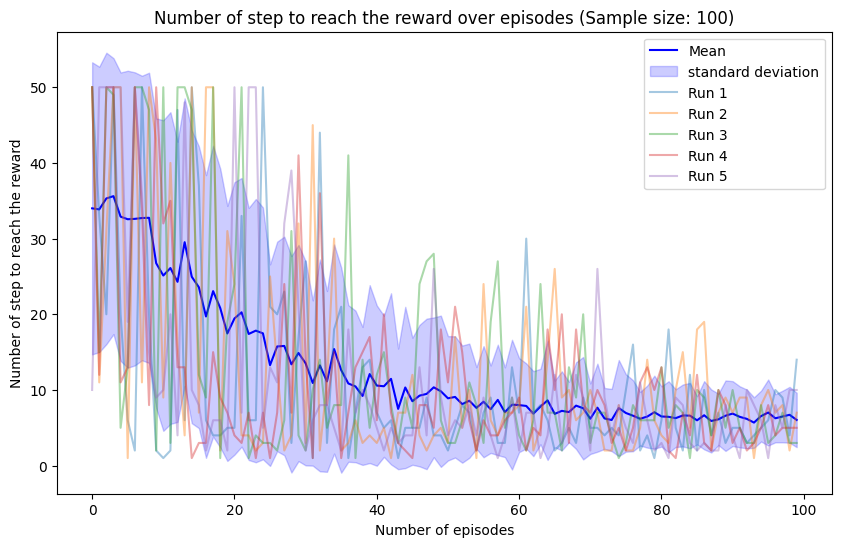

<Figure size 640x480 with 0 Axes>

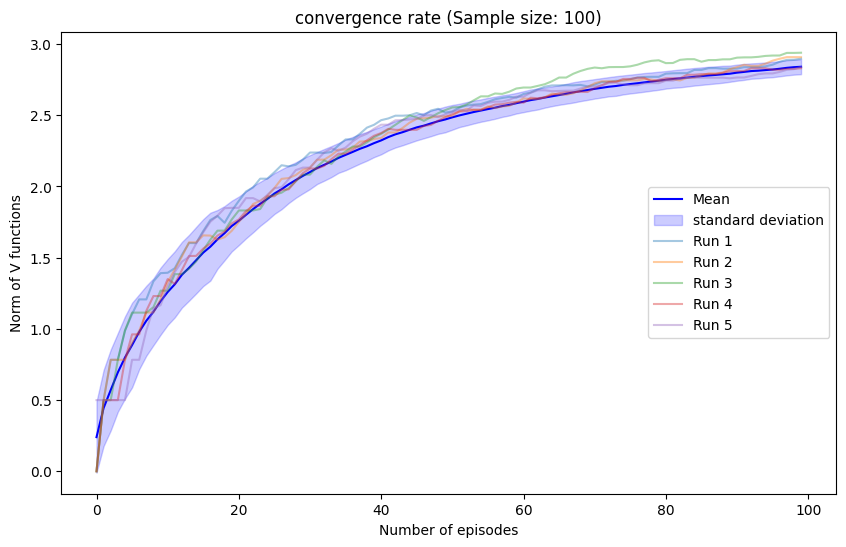

In [21]:
torch.manual_seed(2)

env2 = gym.make(
    conf.mdp.name,
    kwargs={"width": conf.mdp.width, "height": conf.mdp.width, "ratio": conf.mdp.ratio, "hit": 0.0},
    render_mode=conf.mdp.render_mode,
)

v_sample, v_list_sample, time_list_sample, policy_sample = sampling(env2, nb_sample=100)
plot_nb_steps(time_list_sample, False)
plot_convergence(v_list_sample, False)

In [72]:
best_params, best_value, study = optimize_hyperparameters(env2, n_trials=400)

[I 2024-09-29 17:04:44,127] A new study created in memory with name: no-name-276510e0-c4a0-45a7-92f3-bbc91e8a7ecd
[I 2024-09-29 17:04:52,654] Trial 0 finished with value: 2.3221223605573424 and parameters: {'actor_lr': 0.05620631510538569, 'critic_lr': 0.3745643867391967}. Best is trial 0 with value: 2.3221223605573424.
[I 2024-09-29 17:04:57,217] Trial 1 finished with value: 2.9915849621828374 and parameters: {'actor_lr': 0.382149607215541, 'critic_lr': 0.6430461708167438}. Best is trial 1 with value: 2.9915849621828374.
[I 2024-09-29 17:05:01,183] Trial 2 finished with value: 3.0875943122111074 and parameters: {'actor_lr': 0.9546032636072512, 'critic_lr': 0.9335297357622672}. Best is trial 2 with value: 3.0875943122111074.
[I 2024-09-29 17:05:05,730] Trial 3 finished with value: 2.8746264801820938 and parameters: {'actor_lr': 0.41394297486029064, 'critic_lr': 0.4140165641970039}. Best is trial 2 with value: 3.0875943122111074.
[I 2024-09-29 17:05:11,232] Trial 4 finished with value: 

In [73]:
optuna.visualization.plot_optimization_history(study)

In [74]:
optuna.visualization.plot_rank(study)

# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [10]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [11]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [12]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [14]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10, color='red')
    plt.plot(steps, central2, linewidth=10, color='blue')
    plt.fill_between(steps, low1, high1, alpha=0.3, color='red')
    plt.fill_between(steps, low2, high2, alpha=0.3, color='blue')
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    
    plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [18]:
naive_hyper_parameters = (0.5, 0.5)
grid_search_hyper_parameters = (0.8420368421052632, 0.8946578947368421)
bayesian_optimization_hyper_parameters = (0.996948471965022, 0.9342176253498784)

def sampling(env, nb_episodes=100, timeout=50, nb_sample=50, alpha_critic = 0.5, alpha_actor = 0.5):

In [19]:
# On créée un nouvel environnement pour tester la généralisation

new_env = gym.make(
    conf.mdp.name,
    kwargs={"width": conf.mdp.width, "height": conf.mdp.width, "ratio": conf.mdp.ratio, "hit": 0.0},
    render_mode=conf.mdp.render_mode,
)

In [24]:
naive_sample = sampling(new_env, nb_episodes=150, nb_sample=3000, alpha_actor=naive_hyper_parameters[0], alpha_critic=naive_hyper_parameters[1])

In [25]:
grid_search_sample = sampling(new_env, nb_episodes=150, nb_sample=3000, alpha_actor=grid_search_hyper_parameters[0], alpha_critic=grid_search_hyper_parameters[1])

In [26]:
bayesian_optimization_sample = sampling(new_env, nb_episodes=150, nb_sample=3000, alpha_actor=bayesian_optimization_hyper_parameters[0], alpha_critic=bayesian_optimization_hyper_parameters[1])

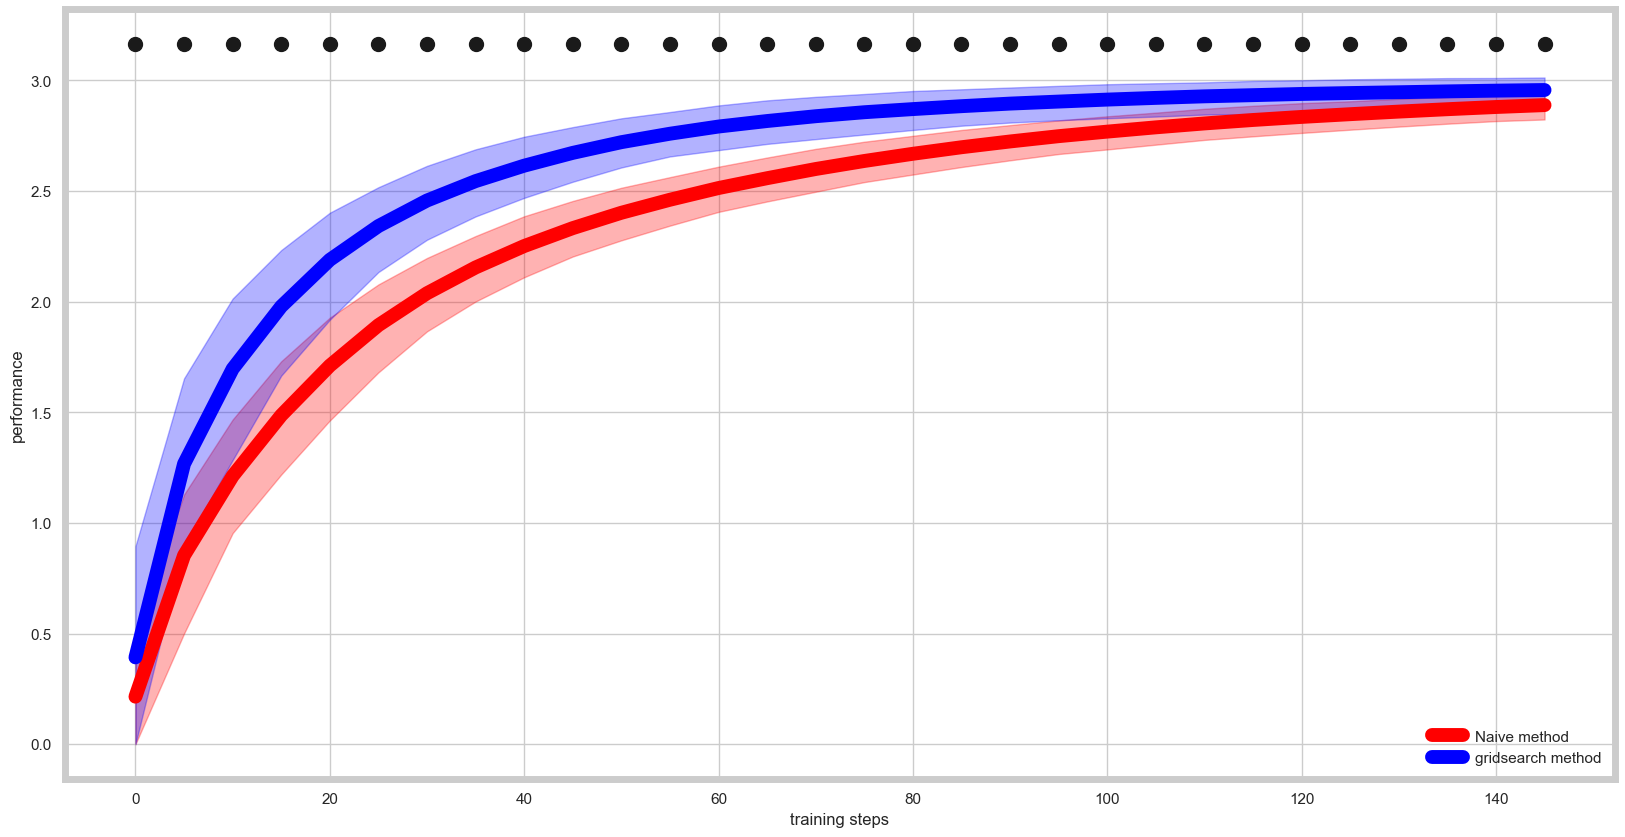

In [30]:
perform_test(np.array(naive_sample[1]), np.array(grid_search_sample[1]), "Naive method", "gridsearch method", 3000)

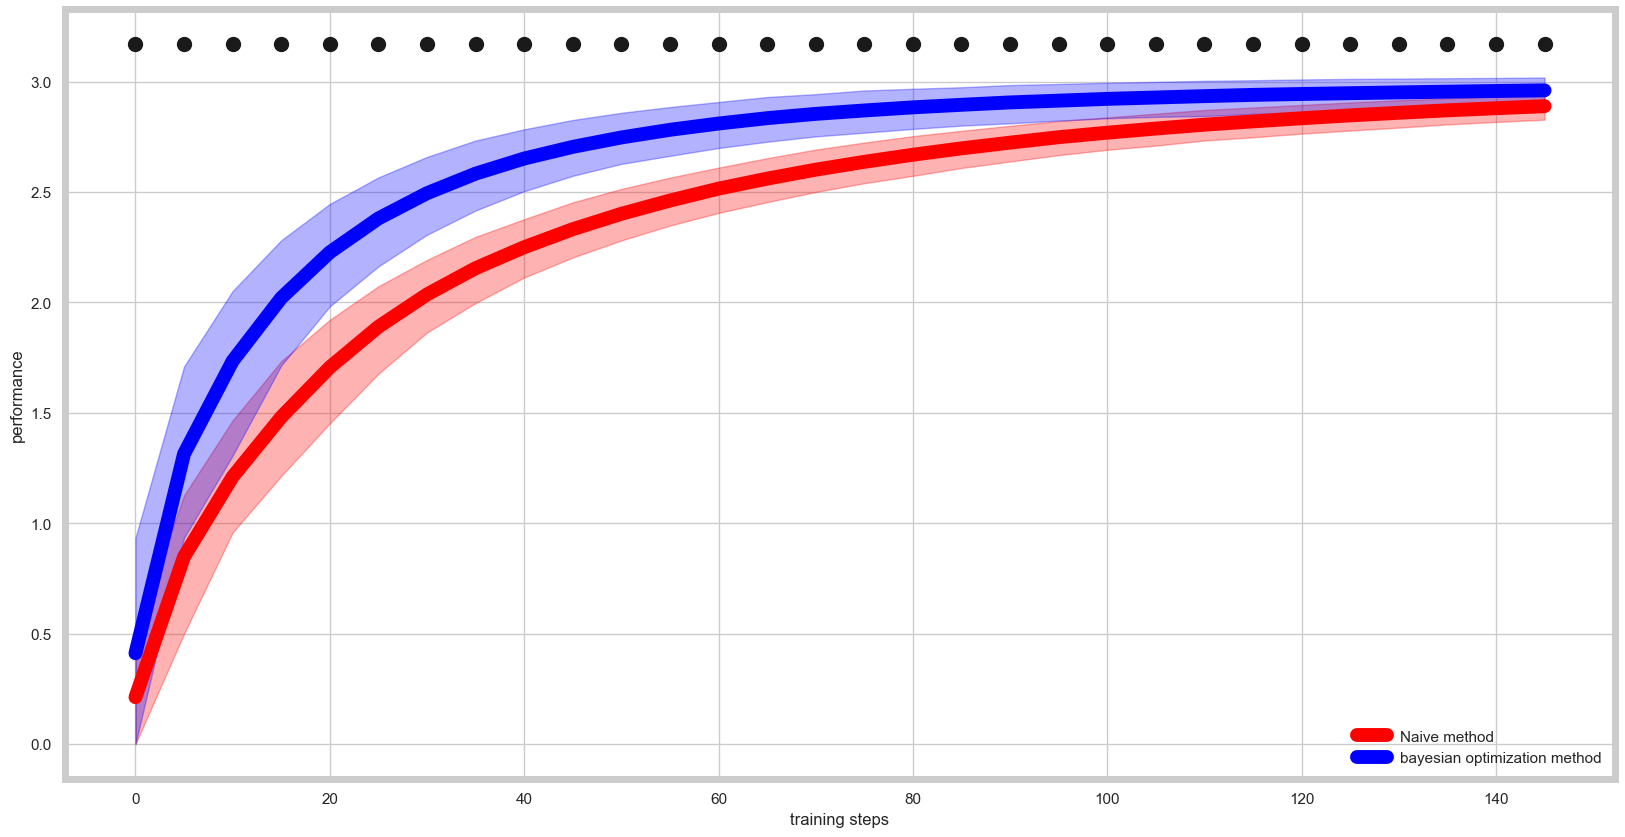

In [31]:
perform_test(np.array(naive_sample[1]), np.array(bayesian_optimization_sample[1]), "Naive method", "bayesian optimization method", 3000)

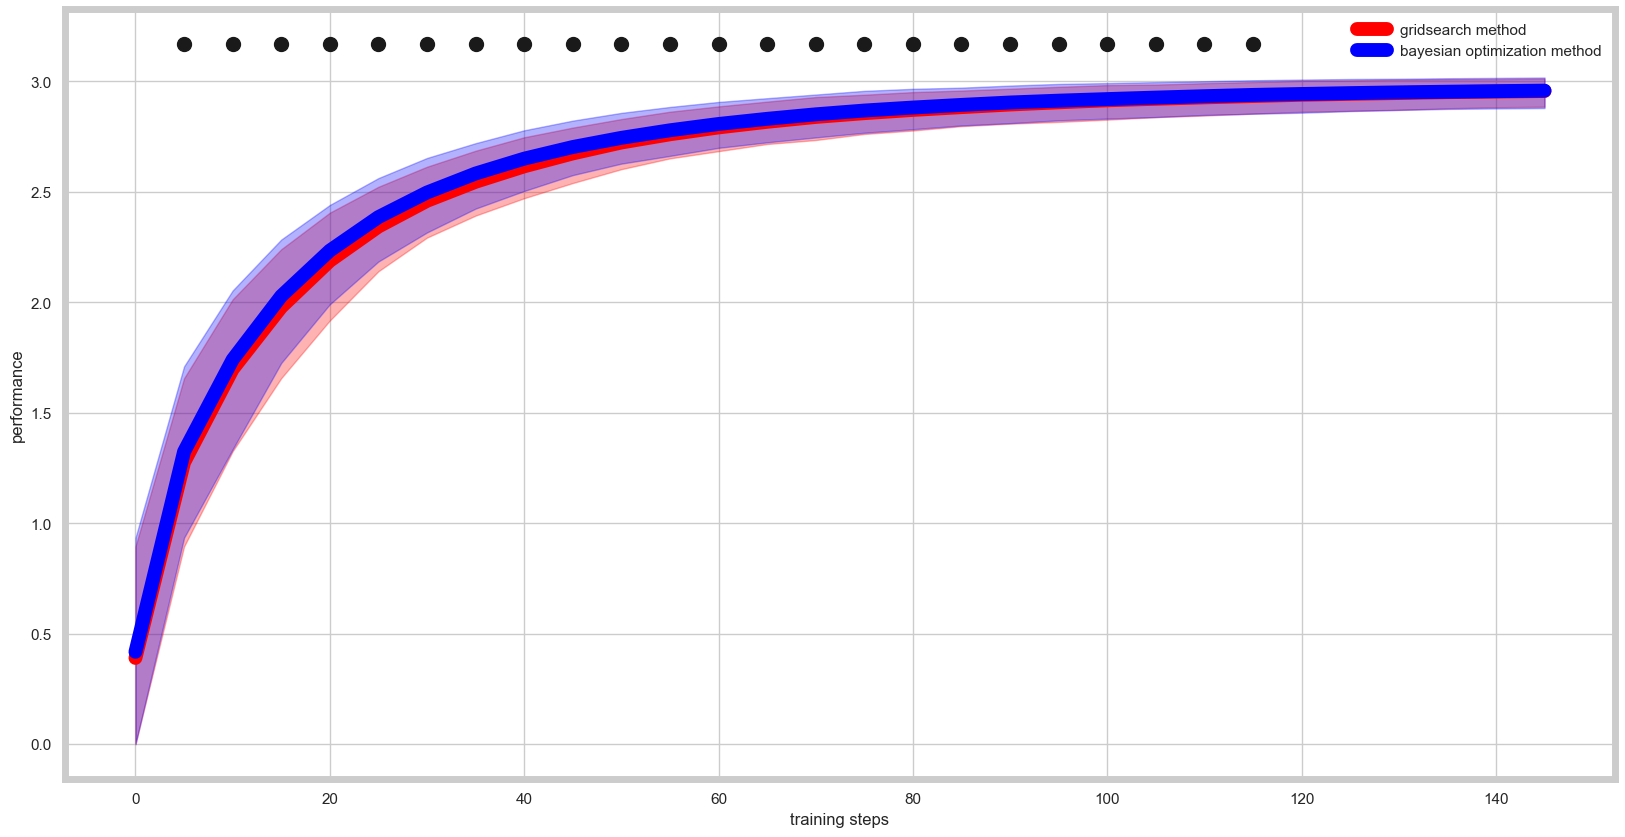

In [32]:
perform_test(np.array(grid_search_sample[1]), np.array(bayesian_optimization_sample[1]), "gridsearch method", "bayesian optimization method", 3000)

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.